## Betting Odds in Soccer: An Analysis on Home Team Advantage and Individual Player Skill

Richard Chen, Keshav Sota, Angela Zhou <br>
Data Bootcamp <br>
Spring 2018

## Abstract

Betting agencies have long existed in the sporting world and are often seen as a form of gambling dictated by team loyalty. We dive deeper into potential factors that influence betting odds. Our analysis leads us to the conclusion that a Home Team Advantage depresses Home Betting Odds across all leagues and that individual star players may also have an effect, although a concrete conclusion is more difficult due to confounding variables across leagues.

## Data Input and Libraries

The data used comes from preset data downloaded from Kaggle. Provided is data from 25,000+ matches, 10,000+ players, 11 European Countries, and betting odds from multiple providers spanning 2008 and 2016. Player and Team data has been sourced from the EA Fifa Video Game Francise. We used Bet 365 Data for our Betting Odds. Data was imported into the Jupyter Notebook using the following code:

In [2]:
import sys
import numpy as np #analysis
import pandas as pd
import matplotlib.pyplot as plt #plotting vizualizations
from math import pi 
import datetime
import seaborn as sns #statistical graphs
from scipy.stats.stats import linregress

plt.style.use("ggplot") #data vizualization

%matplotlib inline


In [3]:
path = "C://Users//Ricky//Desktop//DB Final//Player_Attributes.csv"
path2 = "C://Users//Ricky//Desktop//DB Final///Player.csv"
path3 = "C://Users//Ricky//Desktop//DB Final//Match.csv"
path4 = "C://Users//Ricky//Desktop//DB Final//Team.csv"
PlayerData1 = pd.read_csv(path)
PlayerNames1 = pd.read_csv(path2)
MatchData1 = pd.read_csv(path3)
TeamData1 = pd.read_csv(path4)

#print("Variables dtypes:\n:",PlayerData1.dtypes, sep='')
#print("Variables dtypes:\n:",PlayerNames1.dtypes, sep='')

This section of the code links together a few files. In this instance we are linking the Player Name/Player ID key on one CSV file to the Player Attribute CSV file, which only contains Player ID information. We similarly do this on later with Team Names on the Match CSV file and the Team CSV file to link all the information together. 

In [4]:
PlayerData = PlayerData1[['player_fifa_api_id', 'player_api_id','overall_rating', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]
# Player attributes were called from the data and used to characterize each player
PlayerNames = PlayerNames1[["player_api_id","player_name"]]
# This would later be used to match player API ID's to Player Names
TopPlayers = PlayerData[PlayerData.overall_rating >= 80]
# This was used to select top players
MatchData = MatchData1[["id","league_id","season","match_api_id","home_team_api_id","away_team_api_id","home_team_goal", "away_team_goal", "home_player_1","home_player_2","home_player_3",'home_player_4','home_player_5','home_player_6','home_player_7','home_player_8','home_player_9','home_player_10','home_player_11','away_player_1','away_player_2','away_player_3','away_player_4','away_player_5','away_player_6','away_player_7','away_player_8','away_player_9','away_player_10','away_player_11','B365H','B365D','B365A']]
# Key match variables were called from the data and used in analysis
TeamData = TeamData1[["team_api_id","team_long_name","team_short_name"]]
# This will later be used to match team API ID's to Team Names

The first step in our analysis was to take a look at matches from a high-level. In order to do this, we began by matching MatchData team API ID values to their respective team names.

In [5]:
HomeTeamData = TeamData.rename(columns={'team_api_id':'home_team_api_id', 'team_long_name':'home_team_long_name','team_short_name':'home_team_short_name'})
AwayTeamData = HomeTeamData.rename(columns={'home_team_api_id':'away_team_api_id', 'home_team_long_name':'away_team_long_name','home_team_short_name':'away_team_short_name'})
#These two dataframes were made to facilitate a simple merge.

In [6]:
print('Dimensions of MatchData:', MatchData.shape)
print('Dimensions of HomeTeamData:', HomeTeamData.shape)

HalfMatchData = pd.merge(MatchData, HomeTeamData,   #First we merged home team IDs
                 how='left',        
                 on='home_team_api_id',     
                 indicator=False) #Since multiple merges will be necessary, we set this False for now.

print('Dimensions of new df:', HalfMatchData.shape)

Dimensions of MatchData: (25979, 33)
Dimensions of HomeTeamData: (299, 3)
Dimensions of new df: (25979, 35)


In [7]:
print('Dimensions of HalfMatchData:', HalfMatchData.shape)
print('Dimensions of AwayTeamData:', AwayTeamData.shape)

AllMatchData = pd.merge(HalfMatchData, AwayTeamData,   #The new dataframe will have both away and home team names matched.
                 how='left',      
                 on='away_team_api_id',     
                 indicator=True) #We now set this True to remember a merge has occured.

print('Dimensions of new df:', AllMatchData.shape)

Dimensions of HalfMatchData: (25979, 35)
Dimensions of AwayTeamData: (299, 3)
Dimensions of new df: (25979, 38)


Now that we have merged these two dataframes, we are ready to begin the first step of our analysis.

## Investigating Home Team Advantage

In [8]:
HomeTeamAdv=AllMatchData[["home_team_long_name", "home_team_goal", "away_team_long_name", "away_team_goal"]]
#The following dataframe contains very basic statistics about each match.

In [9]:
HomeTeamAdv["net_goal"]=HomeTeamAdv["home_team_goal"]-HomeTeamAdv["away_team_goal"]
HomeTeamAdv.head(10)
#Here, we add a new column that will help facilitate our analysis. It marks the difference in goals between the two teams.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,home_team_long_name,home_team_goal,away_team_long_name,away_team_goal,net_goal
0,KRC Genk,1,Beerschot AC,1,0
1,SV Zulte-Waregem,0,Sporting Lokeren,0,0
2,KSV Cercle Brugge,0,RSC Anderlecht,3,-3
3,KAA Gent,5,RAEC Mons,0,5
4,FCV Dender EH,1,Standard de Liège,3,-2
5,KV Mechelen,1,Club Brugge KV,1,0
6,KSV Roeselare,2,KV Kortrijk,2,0
7,Tubize,1,Royal Excel Mouscron,2,-1
8,KVC Westerlo,1,Sporting Charleroi,0,1
9,Club Brugge KV,4,KV Kortrijk,1,3


In [10]:
HomeTeamAdv.shape

(25979, 5)

In [11]:
number_games = len(HomeTeamAdv)
number_wins = sum(a>0 for a in HomeTeamAdv["net_goal"])
number_draw = sum(a==0 for a in HomeTeamAdv["net_goal"])
number_loss = sum(a<0 for a in HomeTeamAdv["net_goal"])
print("Total Games:", number_games)
print("Total Home Wins:", number_wins)
print ("Total Home Draws:", number_draw)
print ("Total Home Loss:", number_loss)
#Using this code, we are able to identify the total number of games won, drawn, and lost for the Home Team.

Total Games: 25979
Total Home Wins: 11917
Total Home Draws: 6596
Total Home Loss: 7466


In [12]:
percentage_wins = number_wins/number_games*100
print(percentage_wins,"% Games Won")
percentage_draw = number_draw/number_games*100
print(percentage_draw,"% Games Won")
percentage_loss = number_loss/number_games*100
print(percentage_loss, "% Games Won")
#We also use the following code to look at the percentage of games that respectively won, drawn, and lost for the Home Team.

45.87166557604219 % Games Won
25.389737865198814 % Games Won
28.738596558759 % Games Won


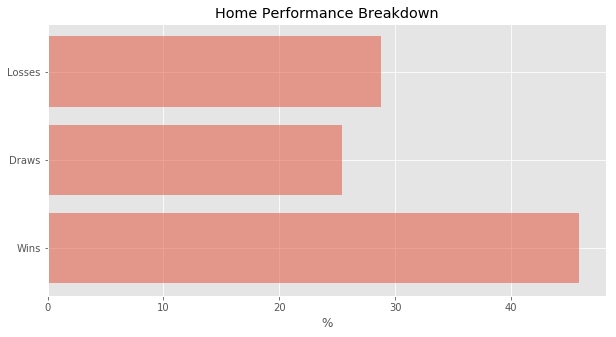

In [13]:
plt.figure(figsize=(10,5)) 
percentages = [percentage_wins, percentage_draw, percentage_loss]
labels = ["Wins","Draws","Losses"]
y_pos = np.arange(len(percentages))
plt.barh(y_pos, percentages, align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.xlabel(r'%')
plt.title('Home Performance Breakdown')
plt.show()

#This simple horizontal bar chart allows us to visualize the difference in proportions of games won, drawn, and lost.

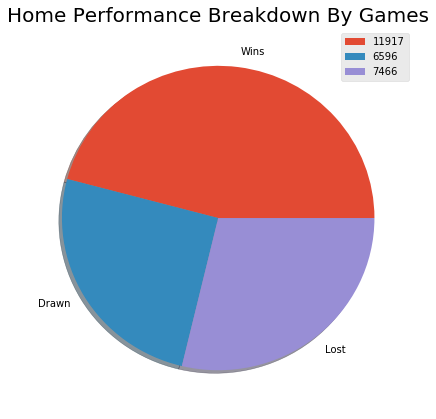

In [14]:
plt.figure(figsize=(7,7)) 
breakdown = [number_wins, number_draw, number_loss]
plt.pie(breakdown, labels=["Wins", "Drawn", "Lost"], shadow=True)
plt.title('Home Performance Breakdown By Games', fontsize=20)
plt.legend([number_wins, number_draw, number_loss])
plt.show()

#An accompagnying pie chart is also included for further visualization.

Given the overwhelming amount of Home wins compard to losses and draws, we believed it reasonable to conclude that a Home Advantage could exist. We can now investigate whether home team advantage has an effect on betting odds on a match by match basis..

In [15]:
MatchAnalysis=AllMatchData[["home_team_long_name", "home_team_goal","away_team_long_name","away_team_goal","B365H","B365D","B365A"]]
MatchAnalysis.head()
#We create a new dataframe to eliminate data that is not needed for the analysis
#We let the number of home goals be a proxy for a combination of home field advantage and relative skill in the match.
#We will run a regression on home_team_goal and B365H to examine whether an apparent correlation exists.

,home_team_long_name,home_team_goal,away_team_long_name,away_team_goal,B365H,B365D,B365A
0,KRC Genk,1,Beerschot AC,1,1.73,3.40,5.00
1,SV Zulte-Waregem,0,Sporting Lokeren,0,1.95,3.20,3.60
2,KSV Cercle Brugge,0,RSC Anderlecht,3,2.38,3.30,2.75
3,KAA Gent,5,RAEC Mons,0,1.44,3.75,7.50
4,FCV Dender EH,1,Standard de Liège,3,5.00,3.50,1.65


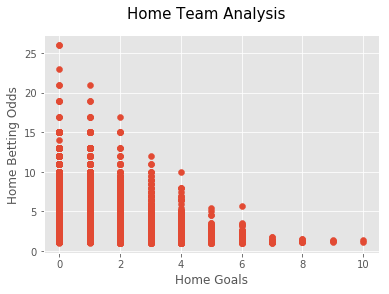

In [18]:
plt.scatter(MatchAnalysis["home_team_goal"],MatchAnalysis["B365H"])
plt.xlabel("Home Goals")
plt.ylabel("Home Betting Odds")
plt.suptitle("Home Team Analysis", fontsize = 15)
plt.show()
#Our analysis of this scatterplot should show a negative relationship between goals or "relative strength" and home betting odds
#We will examine the same for away statistics, but expect a larger spread in betting values due to a lack of home team advantage

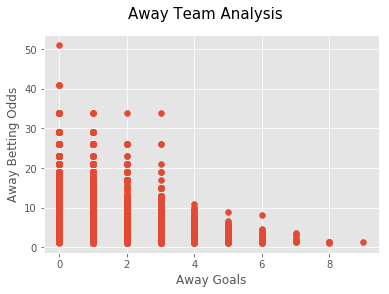

In [19]:
plt.scatter(MatchAnalysis["away_team_goal"],MatchAnalysis["B365A"])
plt.xlabel("Away Goals")
plt.ylabel("Away Betting Odds")
plt.suptitle("Away Team Analysis", fontsize = 15)
plt.show()

The difference between the two scatterplots is slight but significant. The data maps as we would expect. On a match by match basis, we see that home team betting odds are more heavily concentrated towards par 1:1 while away team betting odds experience a much larger spread. We keep in mind that goals scored is not a perfect proxy for skill, but have drawn enough of a conclusion to warrant looking deeper. The data here suggests that betting odds account for home field advantage by depressing home betting odds.

#### Within our analysis, we recognize that there is no absence of confounding variables. We dig deeper to see if we can draw similar conclusions on a league by league basis.

In [20]:
MatchData["Home_Away_Diff"] = MatchData["home_team_goal"] - MatchData["away_team_goal"]
#We return to the original dataframe to prevent confusion and potential errors.
#We create the same variable as our net_goal from above

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
def add_Result(row):
    if row["Home_Away_Diff"] > 0:
        return "Won"
    elif row["Home_Away_Diff"] == 0:
        return "Draw"
    elif row["Home_Away_Diff"] < 1:
        return "Lost"
    else:
        return "error"

MatchData = MatchData.assign(Result=MatchData.apply(add_Result, axis=1))
#We are again taking count of the number of games won, drawn, or lost for the home teams.

In [22]:
MatchData.set_index('league_id', inplace=True)

In [23]:
England = MatchData.loc[1729]
France = MatchData.loc[4769]
Germany = MatchData.loc[7809]
Italy = MatchData.loc[10257]
Spain = MatchData.loc[21518]

#We want to hone in on the leagues that have large fanbases and are likely to have high amounts of betting traffic.

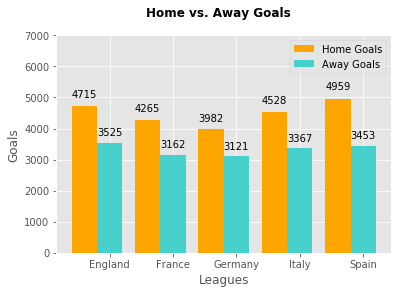

In [24]:
N = 5
ind = np.arange(N)
width = 0.4

fig, ax = plt.subplots()

home_vals = [England.home_team_goal.sum(), France.home_team_goal.sum(), Germany.home_team_goal.sum(), Italy.home_team_goal.sum(), Spain.home_team_goal.sum()]
rects1 = ax.bar(ind, home_vals, width, color='orange')

away_vals = [England.away_team_goal.sum(), France.away_team_goal.sum(), Germany.away_team_goal.sum(), Italy.away_team_goal.sum(), Spain.away_team_goal.sum()]
rects2 = ax.bar(ind+width, away_vals, width, color='mediumturquoise')

fig.suptitle("Home vs. Away Goals", fontweight = 'bold')

ax.set_ylim(0, 7000)
ax.set_ylabel('Goals')
ax.set_xlabel('Leagues')

ax.set_xticks(ind+width)
ax.set_xticklabels(('England', 'France', 'Germany', 'Italy', 'Spain'))
ax.legend((rects1[0], rects2[0]), ('Home Goals', 'Away Goals'))

def autolabel (rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

In this graph, we plotted the total home and away goals for each respective league that we chose to focus on to analyze whether or not there really is a home advantage and how each league did compared to the others. As shown above, its clear that there are significantly higher home goals across the leagues. Teams in the Spain LIGA BBVA league seem to perform the best on their own territory, followed by those in the England Premier League and Italy Serie A League. Interestingly, while there is a significant range of home goals across the leagues, the away goals are around the same number.

In [25]:
win_e, loss_e, draw_e, win_f, loss_f, draw_f, win_g, loss_g, draw_g, win_i, loss_i, draw_i, win_s, loss_s, draw_s = (0,)*15

for row in England.Result:
    if row == "Draw":
        draw_e = draw_e + 1
    elif row =="Won":
        win_e = win_e + 1
    elif row == "Lost":
        loss_e = loss_e + 1

for row in France.Result:
    if row == "Draw":
        draw_f = draw_f + 1
    elif row =="Won":
        win_f = win_f + 1
    elif row == "Lost":
        loss_f = loss_f + 1
        
for row in Germany.Result:
    if row == "Draw":
        draw_g = draw_g + 1
    elif row =="Won":
        win_g = win_g + 1
    elif row == "Lost":
        loss_g = loss_g + 1

for row in Italy.Result:
    if row == "Draw":
        draw_i = draw_i + 1
    elif row =="Won":
        win_i = win_i + 1
    elif row == "Lost":
        loss_i = loss_i + 1

for row in Spain.Result:
    if row == "Draw":
        draw_s = draw_s + 1
    elif row =="Won":
        win_s = win_s + 1
    elif row == "Lost":
        loss_s = loss_s + 1

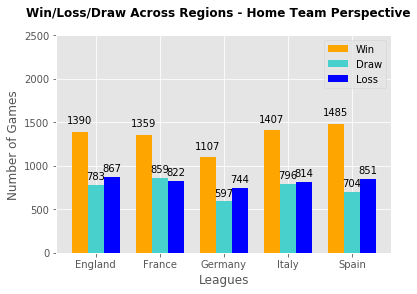

In [26]:
N = 5
ind = np.arange(N)  
width = 0.25

fig, ax = plt.subplots()

yvals = [win_e, win_f, win_g, win_i, win_s]
r1 = ax.bar(ind, yvals, width, color='orange')

zvals = [draw_e, draw_f, draw_g, draw_i, draw_s]
r2 = ax.bar(ind+width, zvals, width, color='mediumturquoise')

kvals = [loss_e, loss_f, loss_g, loss_i, loss_s]
r3 = ax.bar(ind+width*2, kvals, width, color='b')

fig.suptitle("Win/Loss/Draw Across Regions - Home Team Perspective", fontweight = 'bold')

ax.set_ylim(0, 2500)
ax.set_ylabel('Number of Games')
ax.set_xlabel('Leagues')

ax.set_xticks(ind+width)
ax.set_xticklabels(('England', 'France', 'Germany', 'Italy', 'Spain'))
ax.legend( (r1[0], r2[0], r3[0]), ('Win', 'Draw', 'Loss') )

def autolabel(r):
    for r in r:
        h = r.get_height()
        ax.text(r.get_x()+r.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.show()

We also looked at the aggregate wins, losses, and draws in respects to the home team within each region to gain more insight into our analysis of the correlation between leagues and betting. In general, the home team wins more; the exceptions are Germany, which has a much smaller spread between wins and losses, and Spain, which has a much higher number of wins than losses.

**England** -  1 : 0.563 : 0.624

**France** -  1 : 0.632 : 0.605

**Germany** - 1 : 0.539  :  0.672

**Italy**  -  1 : 0.566  : 0.579

**Spain** - 1 : 0.474 : 0.573

The normalized ratios of wins : draws : loss for each league

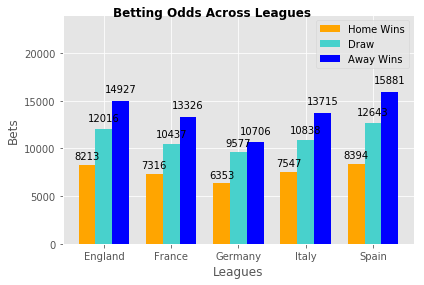

In [27]:
N = 5
ind = np.arange(N)  
width = 0.25

fig, ax = plt.subplots()

yvals = [England.B365H.sum(), France.B365H.sum(), Germany.B365H.sum(), Italy.B365H.sum(), Spain.B365H.sum()]
r1 = ax.bar(ind, yvals, width, color='orange')
zvals = [England.B365D.sum(), France.B365D.sum(), Germany.B365D.sum(), Italy.B365D.sum(), Spain.B365D.sum()]
r2 = ax.bar(ind+width, zvals, width, color='mediumturquoise')
kvals = [England.B365A.sum(), France.B365A.sum(), Germany.B365A.sum(), Italy.B365A.sum(), Spain.B365A.sum()]
r3 = ax.bar(ind+width*2, kvals, width, color='b')

fig.suptitle("Betting Odds Across Leagues", fontweight = 'bold')

ax.set_ylim(0, 24000)
ax.set_ylabel('Bets')
ax.set_xlabel('Leagues')

ax.set_xticks(ind+width)
ax.set_xticklabels(('England', 'France', 'Germany', 'Italy', 'Spain'))
ax.legend( (r1[0], r2[0], r3[0]), ('Home Wins', 'Draw', 'Away Wins') )

def autolabel(r):
    for r in r:
        h = r.get_height()
        ax.text(r.get_x()+r.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(r1)
autolabel(r2)
autolabel(r3)
fig.tight_layout(w_pad=20)

plt.show()

**England** -  1 : 1.46 : 1.82

**France** -  1 : 1.43 : 1.82

**Germany** - 1 : 1.51 : 1.69

**Italy**  -  1  : 1.44 : 1.82

**Spain** - 1 : 1.51 : 1.89

The normalized ratios for home : draw : away betting odds for each league.

Given the previous graphs and data, this one makes sense because given the notion of home advantage, there is a larger payout for the away team if they win. Out of all the leagues, Spain performed the best. This matches our betting odds outcome, with Spain having the highest spread between home and away win betting odds (highest payout if the away team wins because it has the lowest possbility of happening). We also see that the spread is smallest for Germany, which is justified as Germany has the smallest spread between wins and losses.


### Betting Odds Conclusion

Based off of the league data, the negative correlation between home team advantage and betting odds is upheld. In terms of wins:losses, Spain had the largest spread, followed by Italy, France, England, and lastly, Germany. This pattern is reflected in terms of betting odds: Spain had the largest spread, followed by Italy/France/England, and lastly, Germany.

## Investigating Individual Player Effects on Betting Odds

In [28]:
NameMatch= pd.Series(data = PlayerNames["player_name"].values, index = PlayerNames["player_api_id"].values)
TopPlayers["player_name"] = TopPlayers["player_api_id"].map(NameMatch)

# Matches player names from the Player Names Data Frame over to our merged data frame using the map function



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
def best_by_player(df):
    return df.nlargest(1,"overall_rating") #shows highest possible ranking at a given moment in-time 

In [30]:
match = TopPlayers.groupby("player_name")
new_df = pd.DataFrame(match.apply(best_by_player)) #creates a new data frame which gives the highest score for each player 
new_df.set_index("player_api_id") #set_index to player API Id
new_df.head(10)






,,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name
player_name,,,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,166,152747,30895,84.0,right,high,medium,82.0,70.0,38.0,77.0,...,84.0,23.0,25.0,14.0,12.0,25.0,59.0,25.0,25.0,Aaron Lennon
Aaron Ramsey,277,186561,75489,83.0,right,high,high,74.0,77.0,58.0,84.0,...,76.0,65.0,77.0,68.0,6.0,11.0,5.0,10.0,8.0,Aaron Ramsey
Abdulkader Keita,899,157191,31012,82.0,right,medium,medium,75.0,72.0,77.0,73.0,...,84.0,13.0,28.0,23.0,6.0,7.0,8.0,7.0,15.0,Abdulkader Keita
Adam Johnson,1743,165740,24159,82.0,left,high,medium,83.0,77.0,43.0,77.0,...,65.0,38.0,32.0,33.0,8.0,5.0,13.0,13.0,9.0,Adam Johnson
Adam Lallana,1792,180819,37234,80.0,right,high,medium,74.0,73.0,67.0,83.0,...,70.0,30.0,52.0,38.0,6.0,15.0,14.0,8.0,11.0,Adam Lallana
Adel Taarabt,2352,179605,47394,80.0,right,high,medium,75.0,71.0,41.0,79.0,...,76.0,28.0,29.0,32.0,8.0,7.0,11.0,7.0,13.0,Adel Taarabt
Adem Ljajic,2400,190544,155738,81.0,right,high,medium,75.0,80.0,48.0,78.0,...,66.0,23.0,40.0,40.0,6.0,14.0,7.0,6.0,12.0,Adem Ljajic
Aderlan Santos,2418,213374,361710,80.0,right,medium,medium,34.0,34.0,84.0,63.0,...,60.0,82.0,86.0,78.0,10.0,13.0,13.0,8.0,12.0,Aderlan Santos
Adil Rami,2523,183280,77741,84.0,right,high,medium,52.0,47.0,87.0,70.0,...,54.0,84.0,88.0,81.0,9.0,15.0,12.0,6.0,5.0,Adil Rami


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,0.98,'Player Distribution')

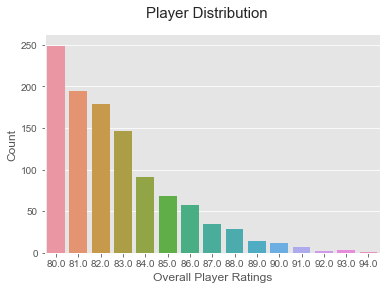

In [31]:
RatingScores = sns.countplot(x = new_df['overall_rating']) #creates the graph using the searborn package
sns.set_style('ticks')
sns.despine() #sets the spines off for the graph 
plt.xlabel("Overall Player Ratings")
plt.ylabel("Count")
plt.suptitle("Player Distribution", fontsize = 15)

In this portion of the project, we wanted to compare how top players are compared to other players. Lionel Messi has been a top player since 2008/2009, we benchmarked his average stats compared to other players, also called spread, to see how it best stacks up. Here, we tried establishing a correlation between Overall Rating and the average of the player attributes 

In [32]:
cols = ['overall_rating','crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']
spread_df = new_df[cols] #finds information for select columns 
spread_df["average"] = pd.DataFrame(spread_df.mean(axis=1))

x = float(spread_df["average"].loc[["Lionel Messi"]]) #in order to compare, we need to create this variable as a float, else the types don't match up 

spread_df["Spread"] = pd.to_numeric(spread_df["average"])-x #benchmarks each player to Lionel Messi's average
spread_df.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,,overall_rating,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,average,Spread
player_name,,,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,166,84.0,82.0,70.0,38.0,77.0,69.0,90.0,62.0,53.0,59.0,...,49.0,81.0,77.0,79.0,84.0,23.0,25.0,14.0,67.793103,-7.241379
Aaron Ramsey,277,83.0,74.0,77.0,58.0,84.0,78.0,81.0,64.0,70.0,82.0,...,75.0,72.0,84.0,81.0,76.0,65.0,77.0,68.0,75.482759,0.448276
Abdulkader Keita,899,82.0,75.0,72.0,77.0,73.0,69.0,86.0,69.0,57.0,76.0,...,75.0,37.0,85.0,70.0,84.0,13.0,28.0,23.0,70.965517,-4.068966
Adam Johnson,1743,82.0,83.0,77.0,43.0,77.0,66.0,86.0,76.0,75.0,71.0,...,61.0,47.0,80.0,80.0,65.0,38.0,32.0,33.0,69.586207,-5.448276
Adam Lallana,1792,80.0,74.0,73.0,67.0,83.0,72.0,85.0,77.0,66.0,74.0,...,46.0,61.0,76.0,83.0,70.0,30.0,52.0,38.0,70.068966,-4.965517


Text(0.5,0.98,'Ratings vs. Spread')

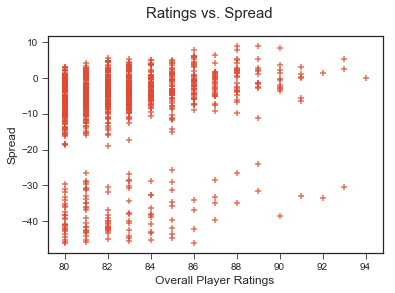

In [33]:
sns.regplot(x = spread_df['overall_rating'], y=spread_df['Spread'], fit_reg=False, marker = "+")
plt.xlabel("Overall Player Ratings") 
plt.ylabel("Spread")
plt.suptitle("Ratings vs. Spread", fontsize = 15)

#creates a scatterplot with markers that are an + using the seaborn package 

In [34]:
linregress(spread_df["overall_rating"],spread_df["Spread"]) #regresesion to find p and r value 

LinregressResult(slope=0.58689250160087603, intercept=-56.030921326252191, rvalue=0.13204113142152654, pvalue=1.2685134607551335e-05, stderr=0.13381825383633952)

Based on this, there is no statistical significance between player attributes and overall player ratings! 

Another thing we wanted to do was to generate radar charts for top players to see how their attributes map out to other players. We created a radar chart for Lionel Messi and Cristiano Ronaldo. 

In [35]:
labels = np.array(['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle'])
stats = new_df.loc[["Lionel Messi"],labels].values[0]
#finds specific stats for Lionel Messi 


In [36]:
angles=np.linspace(0, 2*np.pi, len(labels), endpoint = False)  #dtermines number of angles it should break down into 
#close the plot
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))

#merges into one list of 28 

Text(0.5,0.98,'Lionel Messi Radar Chart')

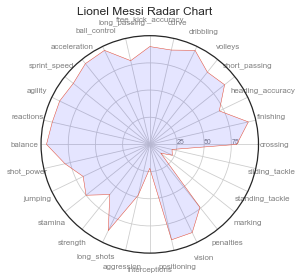

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #sets the graph as a polar graph 
plt.xticks(angles[:-1], labels, color='grey', size=8)
ax.set_rlabel_position(0) #creates the graph (R-theta polar coordinate) from r = 0 
plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
plt.ylim(0,100)
ax.plot(angles,stats, linewidth=.5, linestyle='solid')
ax.fill(angles, stats, 'b', alpha=0.1) #fills in the graph 
ax.grid(True)


plt.suptitle("Lionel Messi Radar Chart") #title 


Text(0.5,0.98,'Cr7 Radar Chart')

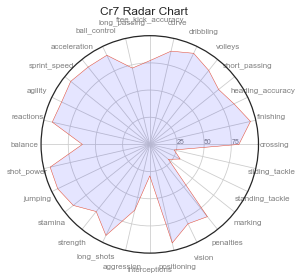

In [38]:
labels = np.array(['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle'])
stats = new_df.loc["Cristiano Ronaldo",labels].values[0]
angles=np.linspace(0, 2*np.pi, len(labels), endpoint = False)  #dtermines number of angles it should break down into 
#close the plot
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
plt.xticks(angles[:-1], labels, color='grey', size=8)
ax.set_rlabel_position(0)
plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
plt.ylim(0,100)
ax.plot(angles,stats, linewidth=.5, linestyle='solid')
ax.fill(angles, stats, 'b', alpha=0.1)
ax.grid(True)


plt.suptitle("Cr7 Radar Chart")

#same thing what we did before for Lionel Messi for Cristiano Ronaldo 

In [39]:
new_df.head()

,,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name
player_name,,,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,166,152747,30895,84.0,right,high,medium,82.0,70.0,38.0,77.0,...,84.0,23.0,25.0,14.0,12.0,25.0,59.0,25.0,25.0,Aaron Lennon
Aaron Ramsey,277,186561,75489,83.0,right,high,high,74.0,77.0,58.0,84.0,...,76.0,65.0,77.0,68.0,6.0,11.0,5.0,10.0,8.0,Aaron Ramsey
Abdulkader Keita,899,157191,31012,82.0,right,medium,medium,75.0,72.0,77.0,73.0,...,84.0,13.0,28.0,23.0,6.0,7.0,8.0,7.0,15.0,Abdulkader Keita
Adam Johnson,1743,165740,24159,82.0,left,high,medium,83.0,77.0,43.0,77.0,...,65.0,38.0,32.0,33.0,8.0,5.0,13.0,13.0,9.0,Adam Johnson
Adam Lallana,1792,180819,37234,80.0,right,high,medium,74.0,73.0,67.0,83.0,...,70.0,30.0,52.0,38.0,6.0,15.0,14.0,8.0,11.0,Adam Lallana


In this section of the code, we found what team each player played for, allowing us to compile more team-based information. The purpose of this section was to see how the overall rating for a team corresponded with betting odds. 

Problem 1: None of the excel files were linked together. For example, in this instance, we did not know what team each player played for. In this section, we map player to the team that they play for. 

In [40]:
new_df["Team_Name"] = np.nan  #creates a new column with no entries - this allows us to fill it in later
variables = ["player_api_id","overall_rating","Team_Name"] #specifies what variables we are looking for 
new_df = new_df[variables]
new_df.head(2)

,,player_api_id,overall_rating,Team_Name
player_name,,,,
Aaron Lennon,166,30895,84.0,NaN
Aaron Ramsey,277,75489,83.0,NaN


In [41]:
#i = 0 
TeamName = [] 


#for PlayerId in new_df.player_api_id: 
for pInd, pRow in new_df.iterrows(): #goes through our data frame row by row 
    PlayerId = pRow.player_api_id #sets player value to match for 
    found = False  
    for index,row in MatchData.iterrows():  #row by row in the MatchData file 
        for y in range(1,12): #goes through the columns for Home_Player_1 to Home_Player_12
            if row["home_player_"+str(y)] == PlayerId: 
                new_df.at[pInd,"Team_Name"] = row["home_team_api_id"] #if there's a match, add that value to that specfic cell and break  
                print("matched")
                found = True 
                break 
        if found == True:
            break 
    #if i > 5:
     #   break 
    #i += 1 
new_df.head(2)

            
new_df.shape
     


    
                                                    

matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched


matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched


(1086, 3)

In [42]:
TeamMatch= pd.Series(data = TeamData["team_long_name"].values, index = TeamData["team_api_id"].values)
new_df["Team_Long_Name"] = new_df["Team_Name"].map(TeamMatch)


#assigns team names 




In [43]:
team_df = new_df.groupby("Team_Long_Name").mean() #consolidates all the teams and finds average of the overall_rating
team_df = team_df.reset_index()
team_df.head(10)


,Team_Long_Name,player_api_id,overall_rating,Team_Name
0,1. FC Köln,94800.400000,82.600000,8722.0
1,1. FC Nürnberg,77897.000000,82.666667,8165.0
2,1. FSV Mainz 05,156752.500000,80.000000,9905.0
3,AC Ajaccio,35179.000000,83.500000,8576.0
4,AC Arles-Avignon,41464.000000,83.000000,108893.0
5,AJ Auxerre,33381.000000,82.333333,8583.0
6,AS Monaco,98574.933333,82.133333,9829.0
7,AS Saint-Étienne,29062.428571,81.571429,9853.0
8,Ajax,37643.000000,83.000000,8593.0
9,Arsenal,41428.314286,83.800000,9825.0


Problem 3: In this portion of the code, we create a new data frame for Bet 365 Betting odds. We create a new column, called spread, which calculates the difference between home price and away/draw odds. Since this is a new data frame from a seperate CSV file, we had to once again map it to the team names as well.

In [44]:
MatchDataF = MatchData1[["home_team_api_id","B365H","B365D","B365A"]] #new data frame that extracts value from the MatchData CSV 
MatchDataF["B.Spread"] = MatchDataF["B365H"] - MatchDataF["B365D"] - MatchDataF['B365A'] #the more negative, the stronger oddsmaker price them
MatchDataF.groupby("home_team_api_id").mean() #finds the mean for specific variables team by team 

MatchDataF.shape

TeamMatch= pd.Series(data = TeamData["team_long_name"].values, index = TeamData["team_api_id"].values)
MatchDataF["Team_Unique_Name"] = MatchDataF["home_team_api_id"].map(TeamMatch) #matches team names with team values 

cols = ["Team_Unique_Name","home_team_api_id","B365H","B365D","B365A","B.Spread"]


MatchDataF = MatchDataF[cols]
MatchDataF.sort_values(by = ["Team_Unique_Name"]) #sorts alphabetically
MatchDataF.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Team_Unique_Name,home_team_api_id,B365H,B365D,B365A,B.Spread
0,KRC Genk,9987,1.73,3.40,5.00,-6.67
1,SV Zulte-Waregem,10000,1.95,3.20,3.60,-4.85
2,KSV Cercle Brugge,9984,2.38,3.30,2.75,-3.67
3,KAA Gent,9991,1.44,3.75,7.50,-9.81
4,FCV Dender EH,7947,5.00,3.50,1.65,-0.15


In [45]:
for pInd, pRow in team_df.iterrows(): #matches values one from data frame to the other 
    TeamId = pRow.Team_Name
    found = False  
    for index,row in MatchDataF.iterrows():  #rowbyrow 
        if row["home_team_api_id"] == TeamId: # if there is a match, then add a new column to our original dataframe
            team_df.at[pInd,"B365H"] = row["B365H"]
            team_df.at[pInd,"B365D"] = row["B365D"]
            team_df.at[pInd,"B365A"] = row["B365A"]
            team_df.at[pInd,"B.Spread"] = row["B.Spread"]
            print("matched")
            found = True 
            break 
 
    #if i > 5:
     #   break 
    #i += 1 
team_df.head(155)

            

matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched
matched


,Team_Long_Name,player_api_id,overall_rating,Team_Name,B365H,B365D,B365A,B.Spread
0,1. FC Köln,94800.400000,82.600000,8722.0,2.62,3.30,2.60,-3.28
1,1. FC Nürnberg,77897.000000,82.666667,8165.0,3.50,3.30,2.10,-1.90
2,1. FSV Mainz 05,156752.500000,80.000000,9905.0,3.80,3.40,2.00,-1.60
3,AC Ajaccio,35179.000000,83.500000,8576.0,2.63,3.00,2.88,-3.25
4,AC Arles-Avignon,41464.000000,83.000000,108893.0,7.00,4.00,1.50,1.50
5,AJ Auxerre,33381.000000,82.333333,8583.0,2.10,3.10,3.75,-4.75
6,AS Monaco,98574.933333,82.133333,9829.0,2.40,3.10,3.10,-3.80
7,AS Saint-Étienne,29062.428571,81.571429,9853.0,1.73,3.50,5.00,-6.77
8,Ajax,37643.000000,83.000000,8593.0,1.17,7.50,13.00,-19.33
9,Arsenal,41428.314286,83.800000,9825.0,1.20,6.50,15.00,-20.30


Here, we create a scatter plot to determine if there was any sort of correlation or not. 

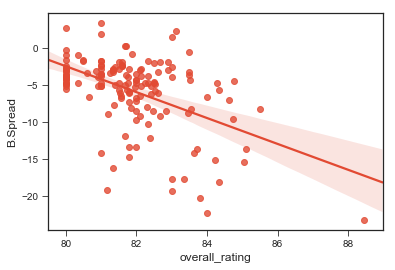

In [46]:
sns.regplot(x = team_df['overall_rating'], y=team_df['B.Spread']) #regression using Seaborn package 


Based on this scatterplot, we see a very slight correlation that exists between a team's overall rating and the betting spreads. The reason that we have hypothesized that such is the case is due to the disparity in the leagues. For example, certain leagues, despite being weaker than their international counterparts, have relatively more consolidated leagues where the winner is predictable. As a result, betting in those leagues means that their spread will always be much more negative, despite being fundamentally a worse team based on their team's overall rating compared to teams in other leagues. In short, the analysis is likely clouded by ommitted variables and a concrete conclusion is difficult with the data used.

### Source

https://www.kaggle.com/hugomathien/soccer/data